<a href="https://colab.research.google.com/github/poudelmohit/carnivore_scat_samples_extraction/blob/main/listing_samples_to_extract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# this notebook is designed to help lab mates select the next samples to select:

In [8]:
import os
from google.colab import drive

MOUNTPOINT = '/content/gdrive'
drive.mount(MOUNTPOINT)

DATADIR = os.path.join(MOUNTPOINT, 'My Drive', 'Colab Notebooks', 'LAB', 'listing_samples_to_extract')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
import geopandas as gpd
import requests
import zipfile
import io
import os

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px

### Files I need:
- Carnivore_working_database # has initial data of the all samples (before extraction)
- Carnivore_working_database # has info of extracted samples
- Indiana County Shapefiles
- Ohio Samples Cordinates file (decided to work later for Ohio Samples)


In [10]:
### https://catmailohio-my.sharepoint.com/:x:/g/personal/tarsoly_ohio_edu/EfG7GB0EGEJGtFH9jlNbSwoBPDLFQYyIfEJMTgBFfwW2Kg?email=mp067823%40ohio.edu&e=yEc8IP

In [39]:
# importing required files:
indiana_shapefile = gpd.read_file(os.path.join(DATADIR, 'indiana_county_shapefiles','indiana_counties.shp'))

carnivore_working_db = pd.read_excel(os.path.join(DATADIR, 'Carnivore.Diet_Working.Database.xlsx'), sheet_name='Database')
box_G = pd.read_excel(os.path.join(DATADIR, 'Carnivore.Diet_Working.Database.xlsx'), sheet_name='Box G')
successful_extractions = pd.read_excel(os.path.join(DATADIR, 'Carnivore.Diet_Working.Database.xlsx'), sheet_name='Total Successful Extractions')



making a clear and consise df that includes only "useful" row and columns:

In [40]:
print(carnivore_working_db.columns.sort_values())
print(box_G.columns.sort_values())

Index(['Box', 'CONDITION', 'COUNTY', 'DATE', 'EASTING', 'Freezer', 'HUMIDITY',
       'LATITUDE', 'LONGITUDE', 'NORTHING', 'NOTES', 'PRECIPITATION', 'SCATID',
       'TEMPERATURE', 'TIME', 'YEAR'],
      dtype='object')
Index(['CONDITION', 'COUNTY', 'DATE', 'EASTING', 'HUMIDITY', 'ICE?',
       'LATITUDE', 'LONGITUDE', 'NORTHING', 'NOTES', 'PRECIPITATION', 'SCATID',
       'TEMPERATURE', 'TIME', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'YEAR', 'box assignment'],
      dtype='object')


In [41]:
### 1.1: combined Box_G and carnivore_working_db:

# delete vacant and unwanted column:
carnivore_working_db.drop(columns=["Freezer", "EASTING", "NORTHING", "YEAR", "TIME"], axis=1, inplace=True)
box_G.drop(columns = ["EASTING", "NORTHING", "YEAR", "TIME",  "Unnamed: 16", "Unnamed: 17", "Unnamed: 18"], axis=1, inplace=True)

# renaming column name for consistency:
box_G.rename(columns={"box assignment":"Box"}, inplace=True)

In [42]:
print(carnivore_working_db.columns.sort_values())
print(box_G.columns.sort_values())

Index(['Box', 'CONDITION', 'COUNTY', 'DATE', 'HUMIDITY', 'LATITUDE',
       'LONGITUDE', 'NOTES', 'PRECIPITATION', 'SCATID', 'TEMPERATURE'],
      dtype='object')
Index(['Box', 'CONDITION', 'COUNTY', 'DATE', 'HUMIDITY', 'ICE?', 'LATITUDE',
       'LONGITUDE', 'NOTES', 'PRECIPITATION', 'SCATID', 'TEMPERATURE'],
      dtype='object')


In [43]:
# updating values in "Box" column for Box G:
box_G['Box'] = "g"

In [44]:
# merging both df into a new:

combined_df = pd.concat([carnivore_working_db, box_G], axis=0, join="outer")
# combined_df.head()

In [45]:
combined_df['COUNTY'].unique()

array([nan, 'Saint_Joseph', 'Benton', 'LaGrange', 'Carroll', 'DeKalb',
       'White', 'Fountain', 'Montgomery', 'Noble', 'Jefferson', 'Warren',
       'Greene', 'Steuben', 'Newton', 'Crawford', 'Lawrence', 'Jasper',
       'Brown', 'Washington', 'Martin', 'not given', 'Perry', 'Jackson',
       'Dubois', 'Marshall', 'Ripley', 'data not provided'], dtype=object)

In [46]:
# at this point, we have 1038 rows, but we have multiple rows without long-lat, DATE of collection, and/or scatID, which needs to be removed:
combined_df = combined_df[~combined_df["COUNTY"].isin(["not given","data not provided"])]
combined_df = combined_df[~combined_df["DATE"].isnull()]

# also removing duplicate entries:
combined_df = combined_df.drop_duplicates().reset_index(drop=True)

In [47]:
# still same ID as listed into more than one box for some id:

counted = combined_df['SCATID'].value_counts()
counted[counted > 1]

combined_df[combined_df['SCATID'].isin(["3-16-255","4-14-323", "3-14-398"])]
## will talk with ELIZABETH about this !!

,SCATID,Box,DATE,PRECIPITATION,TEMPERATURE,HUMIDITY,CONDITION,NOTES,LATITUDE,LONGITUDE,COUNTY,ICE?
331,3-14-398,10,2021-03-03,No,44.0,56.0,Slightly desiccated,NaN,40.382834,-87.293032,Warren,NaN
389,4-14-323,c,2021-02-23,No,56.0,46.0,Fresh,NaN,38.622736,-86.70387,Martin,NaN
601,3-16-255,5,2020-08-04,No,69.0,65.0,Moderately desiccated,NaN,40.690537,-87.391136,Benton,NaN
910,3-16-255,g,2020-08-04,No,69.0,65.0,Moderately desiccated,NaN,"40.696,","-87.3731,",Benton,NaN
959,4-14-323,g,2021-02-23,No,56.0,46.0,Fresh,NaN,"38.6227,","-86.7039,",Martin,NaN
973,3-14-398,g,2021-03-03,No,44.0,56.0,Slightly desiccated,NaN,"40.3828,","-87.293,",Warren,NaN


In [48]:
combined_df.reset_index(drop=True, inplace=True)

In [49]:
# removing unwanted commas from longitude and latititude columns:

combined_df['LATITUDE'] = combined_df['LATITUDE'].astype(str).str.replace(",","", regex=False)
combined_df['LONGITUDE'] = combined_df['LONGITUDE'].astype(str).str.replace(",","", regex=False)

In [50]:
combined_df

,SCATID,Box,DATE,PRECIPITATION,TEMPERATURE,HUMIDITY,CONDITION,NOTES,LATITUDE,LONGITUDE,COUNTY,ICE?
0,9-10-250,c,2021-04-08,Yes,61.0,74.0,Slightly desiccated,NaN,41.51364597,-86.156212,Saint_Joseph,NaN
1,9-10-251,25,2021-04-08,Yes,70.0,73.0,Slightly desiccated,in a puddle,41.49852961,-86.09818299,Saint_Joseph,NaN
2,3-5-562,k,2021-04-07,No,68.0,58.0,Moderately desiccated,NaN,40.69351633,-87.48188308,Benton,NaN
3,3-5-563,h,2021-04-07,No,69.0,58.0,Slightly desiccated,NaN,40.69825188,-87.51031127,Benton,NaN
4,9-9-248,27,2021-04-07,No,75.0,51.0,Slightly desiccated,NaN,41.70011293,-85.3124969,LaGrange,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
980,3-9-48,g,2020-06-17,No,80.0,43.0,Severely desiccated,CF+SF 50/50 habitat type,40.852,-86.736,White,NaN
981,3-7-65,g,2020-06-24,No,73.0,52.0,Severely desiccated,NaN,40.6776,-86.9117,White,NaN
982,3-18-205,g,2020-08-03,No,78.0,65.0,Severely desiccated,NaN,40.6232,-86.8468,White,NaN
983,3-20-263,g,2020-08-11,No,74.0,79.0,Moderately desiccated,NaN,40.8781,-86.6374,White,NaN


# add season columns:

In [51]:
combined_df["DATE"] = pd.to_datetime(combined_df["DATE"])
combined_df['month']  = combined_df["DATE"].dt.strftime('%B')
combined_df['season'] = None

combined_df.loc[combined_df["month"].isin(['May','June','July', 'August','September']),'season'] = "warm"
combined_df.loc[combined_df["month"].isin(['October','November','December', 'January','February','March', 'April']),'season'] = "cool"


In [52]:
combined_df

,SCATID,Box,DATE,PRECIPITATION,TEMPERATURE,HUMIDITY,CONDITION,NOTES,LATITUDE,LONGITUDE,COUNTY,ICE?,month,season
0,9-10-250,c,2021-04-08,Yes,61.0,74.0,Slightly desiccated,NaN,41.51364597,-86.156212,Saint_Joseph,NaN,April,cool
1,9-10-251,25,2021-04-08,Yes,70.0,73.0,Slightly desiccated,in a puddle,41.49852961,-86.09818299,Saint_Joseph,NaN,April,cool
2,3-5-562,k,2021-04-07,No,68.0,58.0,Moderately desiccated,NaN,40.69351633,-87.48188308,Benton,NaN,April,cool
3,3-5-563,h,2021-04-07,No,69.0,58.0,Slightly desiccated,NaN,40.69825188,-87.51031127,Benton,NaN,April,cool
4,9-9-248,27,2021-04-07,No,75.0,51.0,Slightly desiccated,NaN,41.70011293,-85.3124969,LaGrange,NaN,April,cool
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,3-9-48,g,2020-06-17,No,80.0,43.0,Severely desiccated,CF+SF 50/50 habitat type,40.852,-86.736,White,NaN,June,warm
981,3-7-65,g,2020-06-24,No,73.0,52.0,Severely desiccated,NaN,40.6776,-86.9117,White,NaN,June,warm
982,3-18-205,g,2020-08-03,No,78.0,65.0,Severely desiccated,NaN,40.6232,-86.8468,White,NaN,August,warm
983,3-20-263,g,2020-08-11,No,74.0,79.0,Moderately desiccated,NaN,40.8781,-86.6374,White,NaN,August,warm


## add columns: qubit, extracted_date using df:successful_extractions (imported from Carnivore.Diet_Working.Database)

In [53]:
successful_extractions_df = pd.read_excel(os.path.join(DATADIR, 'Carnivore.Diet_Working.Database.xlsx'), sheet_name='Total Successful Extractions')
successful_extractions = successful_extractions_df[['Successful Extractions', 'Unnamed: 1']]
successful_extractions = successful_extractions.rename(columns={'Unnamed: 1':'Qubit Values',
                                       'Successful Extractions':'successfully_extracted_ids'})

successful_extractions = successful_extractions.drop(0).reset_index(drop=True)
successful_extractions = successful_extractions.dropna()

In [54]:
all_extracted_ids = successful_extractions_df['All Extractions']
# all_extracted_ids = all_extracted_ids.rename(columns={'All Extractions':'all_extracted_ids'})

# all_extracted_ids = all_extracted_ids.drop(0).reset_index(drop=True)
# all_extracted_ids

In [55]:
all_extracted_ids = all_extracted_ids.rename('all_extracted_ids').drop(0).reset_index(drop=True)

In [56]:
all_extracted_ids[1]

'3-16-528'

In [57]:
successful_extractions.head()

,successfully_extracted_ids,Qubit Values
0,4-22-286,19.6
1,3-2-197,39
2,3-11-464,20.5
3,3-16-528,74.2
4,3-12-172,51.7


### function to get extraction status of a sample from sample-ID:

In [58]:
def get_extraction_info(sample_id):
    sample_id_str = str(sample_id)  # Ensure consistent string type for comparisons

    # Check if the sample_id exists in the dataframe
    if successful_extractions['successfully_extracted_ids'].eq(sample_id_str).any():
        # Retrieve the qubit value or other relevant information
        qubit_values = successful_extractions.loc[successful_extractions['successfully_extracted_ids'] == sample_id_str, 'Qubit Values'].values
        if qubit_values.size > 0:  # Ensure there's a value to access
            qubit_value = qubit_values[0]
            print(f"Successfully extracted, with qubit value: {qubit_value}")
        else:
            print("Successfully extracted, but no qubit value found")

    elif sample_id_str in all_extracted_ids.astype(str).values:
        print("Extraction was unsuccessful")

    elif sample_id_str in combined_df['SCATID'].astype(str).values:
        print("Sample yet to be extracted")

    else:
        print("Sample ID not found")


In [59]:
get_extraction_info("3-12-172")

Successfully extracted, with qubit value: 51.7


## function to select next 10 IDs for extractions:

In [60]:
combined_df.head()

,SCATID,Box,DATE,PRECIPITATION,TEMPERATURE,HUMIDITY,CONDITION,NOTES,LATITUDE,LONGITUDE,COUNTY,ICE?,month,season
0,9-10-250,c,2021-04-08,Yes,61.0,74.0,Slightly desiccated,NaN,41.51364597,-86.156212,Saint_Joseph,NaN,April,cool
1,9-10-251,25,2021-04-08,Yes,70.0,73.0,Slightly desiccated,in a puddle,41.49852961,-86.09818299,Saint_Joseph,NaN,April,cool
2,3-5-562,k,2021-04-07,No,68.0,58.0,Moderately desiccated,NaN,40.69351633,-87.48188308,Benton,NaN,April,cool
3,3-5-563,h,2021-04-07,No,69.0,58.0,Slightly desiccated,NaN,40.69825188,-87.51031127,Benton,NaN,April,cool
4,9-9-248,27,2021-04-07,No,75.0,51.0,Slightly desiccated,NaN,41.70011293,-85.3124969,LaGrange,NaN,April,cool


In [61]:

# Obtain IDs of failed extractions: present in all_extracted_ids but not in successfully_extracted_ids
failed_extraction_ids = list(set(all_extracted_ids) - set(successful_extractions['successfully_extracted_ids']))

# Obtain IDs of unextracted samples: present in combined_df['SCATID'] but not in all_extracted_ids
unextracted_ids = list(set(combined_df['SCATID']) - set(all_extracted_ids))

# Obtain IDs of successful extractions: present in successfully_extracted_ids
successful_extraction_ids = list(set(successful_extractions['successfully_extracted_ids']))

# Optionally, print the results
print("Failed Extraction IDs:", failed_extraction_ids)
print("Unextracted IDs:", unextracted_ids)
print("Successful Extraction IDs:", successful_extraction_ids)


Failed Extraction IDs: ['4-10-408', '9-7-261', '3-7-139', '4-17-339', '3-13-84', '4-12-448', '4-19-344', '9-11-292', '3-18-522', '9-11-296', '4-21-266', '3-5-433', '4-4-318', '3-20-320', '3-14-517', '9-17-198', '4-10-177', '3-14-614', '3-20-619', '3-6-35', '3-20-157', '3-9-82', '4-17-161', '4-19-140', '9-7-4', '9-11-202', '4-21-265', '3-16-440', '4-14-307', '4-14-276', '3-14-397', '9-11-51', '3-18-524', '4-17-163', '9-5-54', '3-19-543', '3-1-78', '4-2-351', '9-3-34', '3-11-330', '4-17-162', '9-3-247', '4-15-121', '4-2-100', '9-11-294', '4-21-326', '3-5-526', '9-18-80', '4-12-458', '9-16-235', '3-20-337', '3-7-296', '3-5-432', '9-8-52', '9-9-248', '4-10-143', '4-17-349', '4-5-170', '9-11-299', '3-8-326', '3-2-47', '4-12-249', '4-12-456', '3-20-603', '3-6-605', '4-19-321', '3-14-512', '3-1-46', '3-6-128', '9-9-216', '3-9-80', '3-12-445', '3-14-556', '3-20-159', '4-8-300', '4-7-139', '3-20-336', '3-5-527', '4-10-173', '3-6-521', '9-16-254', '3-7-380', '9-17-103', '4-17-346', '9-9-286', '4

In [62]:
combined_df['status'] = "unknown"

# Function to determine status based on set membership
def determine_status(scatid):
    if scatid in unextracted_ids:
        return 'unextracted'
    elif scatid in failed_extraction_ids:
        return 'extraction failed'
    elif scatid in successful_extraction_ids:
        return 'successfully extracted'
    else:
        return 'Unknown'  # If the SCATID is not found in any set

# Apply the function to the SCATID column to create the status column
combined_df['status'] = combined_df['SCATID'].apply(determine_status)

combined_df.head()

,SCATID,Box,DATE,PRECIPITATION,TEMPERATURE,HUMIDITY,CONDITION,NOTES,LATITUDE,LONGITUDE,COUNTY,ICE?,month,season,status
0,9-10-250,c,2021-04-08,Yes,61.0,74.0,Slightly desiccated,NaN,41.51364597,-86.156212,Saint_Joseph,NaN,April,cool,unextracted
1,9-10-251,25,2021-04-08,Yes,70.0,73.0,Slightly desiccated,in a puddle,41.49852961,-86.09818299,Saint_Joseph,NaN,April,cool,successfully extracted
2,3-5-562,k,2021-04-07,No,68.0,58.0,Moderately desiccated,NaN,40.69351633,-87.48188308,Benton,NaN,April,cool,successfully extracted
3,3-5-563,h,2021-04-07,No,69.0,58.0,Slightly desiccated,NaN,40.69825188,-87.51031127,Benton,NaN,April,cool,extraction failed
4,9-9-248,27,2021-04-07,No,75.0,51.0,Slightly desiccated,NaN,41.70011293,-85.3124969,LaGrange,NaN,April,cool,extraction failed


In [63]:
combined_df['season'].value_counts()

,count
season,
cool,608
warm,377


In [64]:
combined_df

,SCATID,Box,DATE,PRECIPITATION,TEMPERATURE,HUMIDITY,CONDITION,NOTES,LATITUDE,LONGITUDE,COUNTY,ICE?,month,season,status
0,9-10-250,c,2021-04-08,Yes,61.0,74.0,Slightly desiccated,NaN,41.51364597,-86.156212,Saint_Joseph,NaN,April,cool,unextracted
1,9-10-251,25,2021-04-08,Yes,70.0,73.0,Slightly desiccated,in a puddle,41.49852961,-86.09818299,Saint_Joseph,NaN,April,cool,successfully extracted
2,3-5-562,k,2021-04-07,No,68.0,58.0,Moderately desiccated,NaN,40.69351633,-87.48188308,Benton,NaN,April,cool,successfully extracted
3,3-5-563,h,2021-04-07,No,69.0,58.0,Slightly desiccated,NaN,40.69825188,-87.51031127,Benton,NaN,April,cool,extraction failed
4,9-9-248,27,2021-04-07,No,75.0,51.0,Slightly desiccated,NaN,41.70011293,-85.3124969,LaGrange,NaN,April,cool,extraction failed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,3-9-48,g,2020-06-17,No,80.0,43.0,Severely desiccated,CF+SF 50/50 habitat type,40.852,-86.736,White,NaN,June,warm,unextracted
981,3-7-65,g,2020-06-24,No,73.0,52.0,Severely desiccated,NaN,40.6776,-86.9117,White,NaN,June,warm,unextracted
982,3-18-205,g,2020-08-03,No,78.0,65.0,Severely desiccated,NaN,40.6232,-86.8468,White,NaN,August,warm,unextracted
983,3-20-263,g,2020-08-11,No,74.0,79.0,Moderately desiccated,NaN,40.8781,-86.6374,White,NaN,August,warm,unextracted


# Adding 'cluster status' using the long-lat values:

In [65]:
df_to_group_samples = combined_df[['SCATID','LATITUDE','LONGITUDE']]
df_to_group_samples['SCATID'] = df_to_group_samples['SCATID'].apply(lambda x: f"'{x}'")

df_to_group_samples.to_csv(os.path.join(DATADIR, 'df_to_group_samples.csv'), index=False)

<ipython-input-65-50381fea4638>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_group_samples['SCATID'] = df_to_group_samples['SCATID'].apply(lambda x: f"'{x}'")


In [66]:
df_to_group_samples

,SCATID,LATITUDE,LONGITUDE
0,'9-10-250',41.51364597,-86.156212
1,'9-10-251',41.49852961,-86.09818299
2,'3-5-562',40.69351633,-87.48188308
3,'3-5-563',40.69825188,-87.51031127
4,'9-9-248',41.70011293,-85.3124969
...,...,...,...
980,'3-9-48',40.852,-86.736
981,'3-7-65',40.6776,-86.9117
982,'3-18-205',40.6232,-86.8468
983,'3-20-263',40.8781,-86.6374


In [67]:
## Processing in ArcGIS Pro:
"""

# I need to group samples lying within 5km distance, and for that:

1. saved df_to_group_samples.csv to ARCGISPro project

2. Right click >>  Create POints from Table >> XY Table to Point >> selected 1984 WGS

3. As 1984 WGS is NOT suitable for distance calcuation, I need to reproject using 'Project' option.
  After some google search and using https://utmzone.optimumgeospatial.co.ke/, I figured out that UTM Zone 16N is the best option to use.

4. Then, I did 'Group by Proximity' using Planar and 5km as parameters

5. The resulting table was saved as: 'indiana_samples_grouped.csv'
"""

"\n\n# I need to group samples lying within 5km distance, and for that:\n\n1. saved df_to_group_samples.csv to ARCGISPro project\n\n2. Right click >>  Create POints from Table >> XY Table to Point >> selected 1984 WGS\n\n3. As 1984 WGS is NOT suitable for distance calcuation, I need to reproject using 'Project' option.\n  After some google search and using https://utmzone.optimumgeospatial.co.ke/, I figured out that UTM Zone 16N is the best option to use.\n\n4. Then, I did 'Group by Proximity' using Planar and 5km as parameters\n\n5. The resulting table was saved as: 'indiana_samples_grouped.csv'\n"

In [68]:
grouped_indiana_samples = pd.read_csv(os.path.join(DATADIR,'indiana_samples_grouped.csv'))
grouped_indiana_samples

,OBJECTID,SCATID,GROUP_ID
0,1,'9-10-250',5
1,2,'9-10-251',5
2,3,'3-5-562',9
3,4,'3-5-563',9
4,5,'9-9-248',890
...,...,...,...
980,981,'3-9-48',632
981,982,'3-7-65',219
982,983,'3-18-205',601
983,984,'3-20-263',632


In [69]:
grouped_indiana_samples['SCATID'] = grouped_indiana_samples['SCATID'].str.replace("'","", regex=False)

In [70]:
grouped_indiana_samples.drop(axis=1, columns=['OBJECTID'], inplace=True)

In [71]:
grouped_indiana_samples

,SCATID,GROUP_ID
0,9-10-250,5
1,9-10-251,5
2,3-5-562,9
3,3-5-563,9
4,9-9-248,890
...,...,...
980,3-9-48,632
981,3-7-65,219
982,3-18-205,601
983,3-20-263,632


In [72]:
# lets merge combined_df and grouped_indiana_samples based on column SCATID:
merged_indiana_samples = pd.merge(grouped_indiana_samples,combined_df, on='SCATID' )

In [73]:
# while saving in .csv format, excel reformats the SCATID column. So, adding '' to avoid reformatting:
merged_indiana_samples['SCATID'] = merged_indiana_samples['SCATID'].apply(lambda x: f"'{x}'")


In [74]:
merged_indiana_samples[['SCATID','status','GROUP_ID','season','Box','DATE','CONDITION']].to_csv(os.path.join(DATADIR,'gel_image_assessment.csv'), index=False
                                                                                                )

In [79]:
merged_indiana_samples

,SCATID,GROUP_ID,Box,DATE,PRECIPITATION,TEMPERATURE,HUMIDITY,CONDITION,NOTES,LATITUDE,LONGITUDE,COUNTY,ICE?,month,season,status
0,'9-10-250',5,c,2021-04-08,Yes,61.0,74.0,Slightly desiccated,NaN,41.51364597,-86.156212,Saint_Joseph,NaN,April,cool,unextracted
1,'9-10-251',5,25,2021-04-08,Yes,70.0,73.0,Slightly desiccated,in a puddle,41.49852961,-86.09818299,Saint_Joseph,NaN,April,cool,successfully extracted
2,'3-5-562',9,k,2021-04-07,No,68.0,58.0,Moderately desiccated,NaN,40.69351633,-87.48188308,Benton,NaN,April,cool,successfully extracted
3,'3-5-563',9,h,2021-04-07,No,69.0,58.0,Slightly desiccated,NaN,40.69825188,-87.51031127,Benton,NaN,April,cool,extraction failed
4,'9-9-248',890,27,2021-04-07,No,75.0,51.0,Slightly desiccated,NaN,41.70011293,-85.3124969,LaGrange,NaN,April,cool,extraction failed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,'3-9-48',632,g,2020-06-17,No,80.0,43.0,Severely desiccated,CF+SF 50/50 habitat type,40.852,-86.736,White,NaN,June,warm,unextracted
987,'3-7-65',219,g,2020-06-24,No,73.0,52.0,Severely desiccated,NaN,40.6776,-86.9117,White,NaN,June,warm,unextracted
988,'3-18-205',601,g,2020-08-03,No,78.0,65.0,Severely desiccated,NaN,40.6232,-86.8468,White,NaN,August,warm,unextracted
989,'3-20-263',632,g,2020-08-11,No,74.0,79.0,Moderately desiccated,NaN,40.8781,-86.6374,White,NaN,August,warm,unextracted


''' samples exracted by Ciera will not be updated here each week,
  but I need to make decision for next extraction with updated info.
  That's why I am manually editing the samples I assigned to her as successfully extracted at this point'''

In [102]:
cierra_extractions_w1 = ['4-5-51', '4-14-194', '3-8-169', '4-9-73', '3-14-171', '3-16-148', '3-16-149', '3-19-199']
cierra_extractions_w2 = ['4-12-417','4-12-452','4-12-438','4-12-434','4-12-184','4-12-185','4-21-260','4-10-144','4-10-145','4-10-147']
cierra_extractions_w3 = ['4-14-322','4-3-313', '4-14-308','3-6-191','4-11-102','4-11-101','3-6-192','3-15-451','3-15-453']

overall_cierra_extractions = cierra_extractions_w1 + cierra_extractions_w2 + cierra_extractions_w3

overall_cierra_extractions = [f"'{x}'" for x in overall_cierra_extractions]

In [103]:
overall_cierra_extractions

["'4-5-51'",
 "'4-14-194'",
 "'3-8-169'",
 "'4-9-73'",
 "'3-14-171'",
 "'3-16-148'",
 "'3-16-149'",
 "'3-19-199'",
 "'4-12-417'",
 "'4-12-452'",
 "'4-12-438'",
 "'4-12-434'",
 "'4-12-184'",
 "'4-12-185'",
 "'4-21-260'",
 "'4-10-144'",
 "'4-10-145'",
 "'4-10-147'",
 "'4-14-322'",
 "'4-3-313'",
 "'4-14-308'",
 "'3-6-191'",
 "'4-11-102'",
 "'4-11-101'",
 "'3-6-192'",
 "'3-15-451'",
 "'3-15-453'"]

In [109]:
merged_indiana_samples.loc[merged_indiana_samples['SCATID'].isin(overall_cierra_extractions),'status'] = 'cierra_extractions'

In [110]:
merged_indiana_samples['status'].value_counts()

,count
status,
unextracted,692
extraction failed,173
successfully extracted,99
cierra_extractions,27


In [111]:
merged_indiana_samples.head()

,SCATID,GROUP_ID,Box,DATE,PRECIPITATION,TEMPERATURE,HUMIDITY,CONDITION,NOTES,LATITUDE,LONGITUDE,COUNTY,ICE?,month,season,status
0,'9-10-250',5,c,2021-04-08,Yes,61.0,74.0,Slightly desiccated,NaN,41.51364597,-86.156212,Saint_Joseph,NaN,April,cool,unextracted
1,'9-10-251',5,25,2021-04-08,Yes,70.0,73.0,Slightly desiccated,in a puddle,41.49852961,-86.09818299,Saint_Joseph,NaN,April,cool,successfully extracted
2,'3-5-562',9,k,2021-04-07,No,68.0,58.0,Moderately desiccated,NaN,40.69351633,-87.48188308,Benton,NaN,April,cool,successfully extracted
3,'3-5-563',9,h,2021-04-07,No,69.0,58.0,Slightly desiccated,NaN,40.69825188,-87.51031127,Benton,NaN,April,cool,extraction failed
4,'9-9-248',890,27,2021-04-07,No,75.0,51.0,Slightly desiccated,NaN,41.70011293,-85.3124969,LaGrange,NaN,April,cool,extraction failed


In [117]:
# Group by COUNTY and season and count occurrences
extraction_count = merged_indiana_samples[merged_indiana_samples['status'] != "unextracted"][['GROUP_ID','season']].groupby(['GROUP_ID', 'season']).size().unstack(fill_value=0)
available_count = merged_indiana_samples[['GROUP_ID','season']].groupby(['GROUP_ID', 'season']).size().unstack(fill_value=0)

# Percentage of successful extractions:

In [118]:
perc_success = extraction_count/available_count * 100
print(perc_success)

season          cool        warm
GROUP_ID                        
5          20.000000   28.571429
9          46.428571    6.250000
41         28.571429  100.000000
108        33.333333   20.833333
111        33.333333   33.333333
192        50.000000  100.000000
198        77.777778  100.000000
204        50.000000   57.142857
217        40.000000         NaN
219        88.888889   12.500000
231        20.000000   40.000000
268        40.000000   21.739130
337         0.000000   30.000000
379              NaN   50.000000
384              NaN   22.222222
389              NaN         NaN
414       100.000000         NaN
443              NaN         NaN
479        50.000000   20.000000
510        50.000000   40.000000
550        20.000000    0.000000
554        50.000000    0.000000
601        66.666667    0.000000
627        50.000000  100.000000
632        90.909091   55.000000
645        40.000000         NaN
666              NaN         NaN
694        42.857143   33.333333
695       

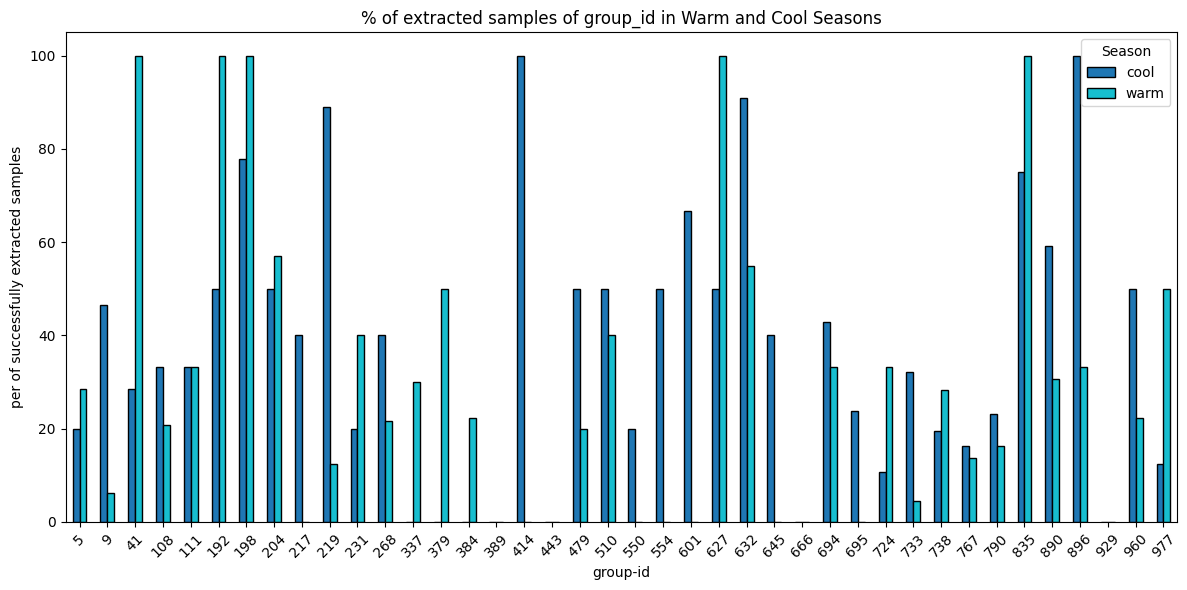

In [119]:


# Plotting
perc_success.plot(kind='bar', figsize=(12, 6), colormap='tab10', edgecolor='black')

plt.title('% of extracted samples of group_id in Warm and Cool Seasons')
plt.xlabel('group-id')
plt.ylabel('per of successfully extracted samples')
plt.xticks(rotation=45)
plt.legend(title='Season')
plt.tight_layout()

plt.show()


## Deciding based on the bar plot:

## for week 1,2 and 3:

In [ ]:
# NO extraction has been done from 'warm' season in Benton, Brown, DeKalb, LaGrange, Martin, Newton, Steuben, Warren, White
# NO extraction has been done from 'cool' season in Dubois, Jackson,

In [ ]:
combined_df[(combined_df['COUNTY'].isin(['Ripley','Marshall'])) & (combined_df['status'].isin(["unextracted"]))][['SCATID','Box','season','COUNTY']]

,SCATID,Box,season,COUNTY
489,9-10-42,12,warm,Marshall
625,4-5-51,1,warm,Ripley


In [ ]:
to_extract_next = combined_df[combined_df['COUNTY'].isin(['Ripley','Martin','Benton','Brown','DeKalb','LaGrange','Martin',
                                        'Newton','Steuben','Warren','White'])][['SCATID','Box','COUNTY','season','status']].sort_values(by=['status','season','Box','COUNTY'], ascending=[False, False, True, True])

In [ ]:
to_extract_next[(to_extract_next['Box'].isin([1,5])) & (to_extract_next['status'] != "successfully extracted")]

### samples recommendation for next week: (Sep week1):

In [ ]:
# decision to ask for extraction in next week:
for_next_week = ['4-5-51', '4-14-194', '3-8-169', '4-9-73', '3-14-171', '3-16-148', '3-16-149', '3-19-199']

### for sep second week:

In [ ]:
to_extract_next_sep_2nd_week = combined_df[['SCATID','Box','COUNTY','season','status','CONDITION']].sort_values(by=['status','season','Box','COUNTY'], ascending=[False, False, True, True])

In [ ]:

to_extract_next_sep_2nd_week[(to_extract_next_sep_2nd_week['COUNTY'].isin(['Brown'])) & (to_extract_next_sep_2nd_week['season'].isin(['warm']))]
# to_extract_next_sep_2nd_week['season']=='cool']

,SCATID,Box,COUNTY,season,status,CONDITION
602,4-22-174,1,Brown,warm,unextracted,Moderately desiccated
603,4-22-182,1,Brown,warm,unextracted,Moderately desiccated
775,4-11-101,1,Brown,warm,unextracted,Fresh
776,4-11-102,1,Brown,warm,unextracted,Fresh
777,4-11-103,1,Brown,warm,unextracted,Moderately desiccated
834,4-9-69,1,Brown,warm,unextracted,Severely desiccated
835,4-9-70,1,Brown,warm,unextracted,Moderately desiccated
836,4-9-71,1,Brown,warm,unextracted,Severely desiccated
837,4-20-74,1,Brown,warm,unextracted,Severely desiccated
838,4-9-68,1,Brown,warm,unextracted,Fresh


In [ ]:
for_next_week = ['4-5-51', '4-14-194', '3-8-169', '4-9-73', '3-14-171', '3-16-148', '3-16-149', '3-19-199']

In [ ]:
for_next_week=['4-14-322','4-3-313','4-14-308','4-14-194','3-6-191','4-11-102','4-11-101','3-6-192','3-15-451','3-15-453']

In [ ]:
def get_samples_info(sample_id):
    # Return the filtered DataFrame with specific columns
    return combined_df[combined_df['SCATID'] == sample_id][['SCATID','Box', 'DATE', 'CONDITION', 'COUNTY', 'season']]

# Initialize an empty list to store the individual DataFrames
samples_info_list = []

# Loop through each sample ID in for_next_week and accumulate the results
for sample in for_next_week:
    samples_info_list.append(get_samples_info(sample))

# Concatenate the list of DataFrames into a single DataFrame
final_df = pd.concat(samples_info_list, ignore_index=True)

# Display the final DataFrame
print(final_df)


     SCATID Box       DATE              CONDITION   COUNTY season
0  4-14-322   5 2021-02-23    Slightly desiccated   Martin   cool
1   4-3-313   5 2021-01-22    Slightly desiccated   Martin   cool
2  4-14-308   5 2021-01-22    Slightly desiccated   Martin   cool
3  4-14-194   1 2020-08-05  Moderately desiccated   Martin   warm
4   3-6-191   7 2020-07-27                  Fresh   Benton   warm
5  4-11-102   1 2020-07-14                  Fresh    Brown   warm
6  4-11-101   1 2020-07-14                  Fresh    Brown   warm
7   3-6-192   6 2020-07-27                  Fresh   Benton   warm
8  3-15-451  27 2021-03-10  Moderately desiccated  Carroll   cool
9  3-15-453  27 2021-03-10  Moderately desiccated  Carroll   cool


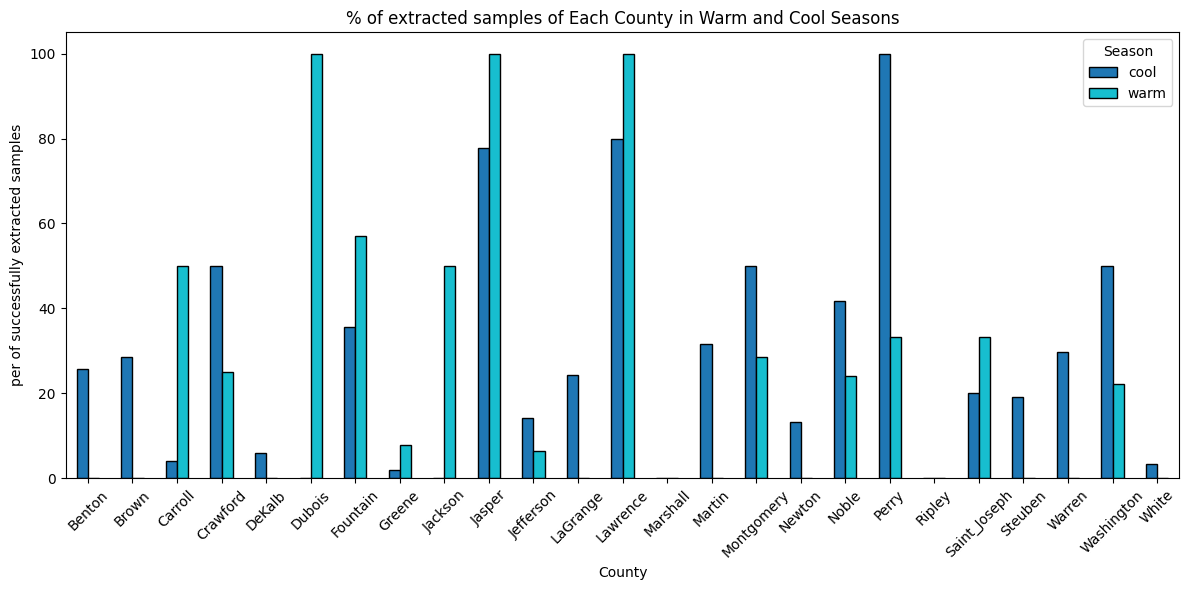

In [ ]:
# Plotting
perc_success.plot(kind='bar', figsize=(12, 6), colormap='tab10', edgecolor='black')

plt.title('% of extracted samples of Each County in Warm and Cool Seasons')
plt.xlabel('County')
plt.ylabel('per of successfully extracted samples')
plt.xticks(rotation=45)
plt.legend(title='Season')
plt.tight_layout()

plt.show()


In [133]:
extraction_status = pd.concat([extraction_count, available_count], axis=1)
extraction_status.columns = ['extracted_cool','extracted_warm','total_cool','total_warm']

In [135]:
# print(perc_success)

# extraction status table for decision making:

In [151]:
# extraction_status

# for week_4:

In [166]:
# merged_indiana_samples[(merged_indiana_samples['GROUP_ID'].isin([550,554,219,601,645,695,733])) & merged_indiana_samples['season'].isin(['warm'])]

In [167]:
for_next_week = ['3-14-251','3-14-252','3-7-180','3-7-181','9-4-150','9-4-151','9-4-132','9-4-133','4-20-74','3-18-205']

In [169]:
def get_samples_info(sample_id):
    # Return the filtered DataFrame with specific columns
    return combined_df[combined_df['SCATID'] == sample_id][['SCATID','Box', 'DATE', 'CONDITION', 'COUNTY', 'season']]

# Initialize an empty list to store the individual DataFrames
samples_info_list = []

# Loop through each sample ID in for_next_week and accumulate the results
for sample in for_next_week:
    samples_info_list.append(get_samples_info(sample))

# Concatenate the list of DataFrames into a single DataFrame
final_df = pd.concat(samples_info_list, ignore_index=True)

# Display the final DataFrame
print(final_df.to_string(index=False))

  SCATID Box       DATE             CONDITION  COUNTY season
3-14-251   7 2020-08-04                 Fresh  Warren   warm
3-14-252   7 2020-08-04                 Fresh  Warren   warm
 3-7-180   6 2020-07-21                 Fresh   White   warm
 3-7-181   6 2020-07-21                 Fresh   White   warm
 9-4-150   8 2020-07-27   Severely desiccated  DeKalb   warm
 9-4-151   8 2020-07-27 Moderately desiccated  DeKalb   warm
 9-4-132   8 2020-07-27   Slightly desiccated Steuben   warm
 9-4-133   8 2020-07-27   Slightly desiccated Steuben   warm
 4-20-74   1 2020-07-07   Severely desiccated   Brown   warm
3-18-205   g 2020-08-03   Severely desiccated   White   warm
